In [31]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor

In [32]:
#Load data
df = pd.read_csv('Crimes_-_2001_to_Present (1).csv')

In [33]:
# Filter the dataset to only include homicides and burglaries
df = df.loc[(df['Primary Type'] == 'HOMICIDE')]

# Convert the 'Date' column to a datetime format
df['Date'] = pd.to_datetime(df['Date'])


In [34]:
# Aggregate the data by year and community area
df = df.groupby(['Year', 'Community Area']).size().reset_index(name='count')


In [35]:
# Split the data into training and testing sets
train = df.loc[df['Year'] < 2019]
test = df.loc[df['Year'] >= 2019]


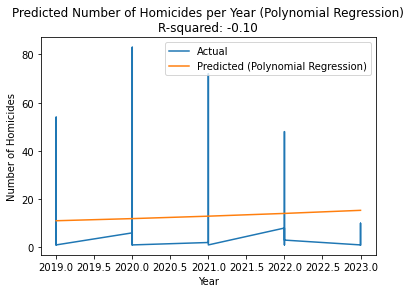

In [39]:
# Option 1: Polynomial Regression
poly_model = LinearRegression()
poly = PolynomialFeatures(degree=3)
X_train = poly.fit_transform(train[['Year']])
X_test = poly.fit_transform(test[['Year']])
poly_model.fit(X_train, train['count'])
poly_preds = poly_model.predict(X_test)
r2 = r2_score(test['count'], poly_preds)
plt.plot(test['Year'], test['count'], label='Actual')
plt.plot(test['Year'], poly_preds, label='Predicted (Polynomial Regression)')
plt.title(f'Predicted Number of Homicides per Year (Polynomial Regression)\nR-squared: {r2:.2f}')
plt.xlabel('Year')
plt.ylabel('Number of Homicides')
plt.legend()
plt.show()

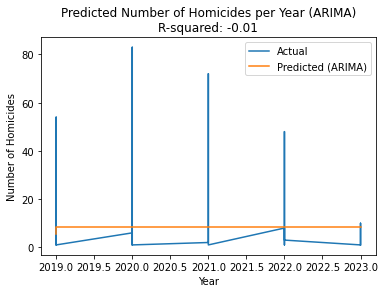

In [40]:
# Option 2: ARIMA Time Series Model
arima_model = ARIMA(train['count'], order=(2,1,2))
arima_results = arima_model.fit()
arima_preds = arima_results.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
r2 = r2_score(test['count'], arima_preds)
plt.plot(test['Year'], test['count'], label='Actual')
plt.plot(test['Year'], arima_preds, label='Predicted (ARIMA)')
plt.title(f'Predicted Number of Homicides per Year (ARIMA)\nR-squared: {r2:.2f}')
plt.xlabel('Year')
plt.ylabel('Number of Homicides')
plt.legend()
plt.show()

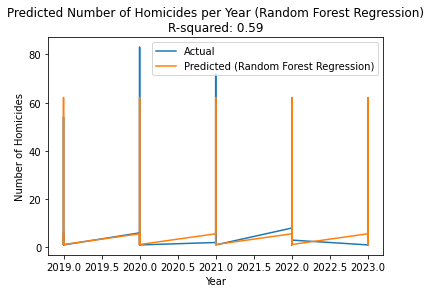

In [41]:
# Option 3: Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train[['Year', 'Community Area']], train['count'])
rf_preds = rf_model.predict(test[['Year', 'Community Area']])
r2 = r2_score(test['count'], rf_preds)
plt.plot(test['Year'], test['count'], label='Actual')
plt.plot(test['Year'], rf_preds, label='Predicted (Random Forest Regression)')
plt.title(f'Predicted Number of Homicides per Year (Random Forest Regression)\nR-squared: {r2:.2f}')
plt.xlabel('Year')
plt.ylabel('Number of Homicides')
plt.legend()
plt.show()

In [45]:
# Create a dataframe with the feature values for all community areas in 2024
features = pd.DataFrame({
    'Year': [2024] * 77, # Assumes 77 community areas
    'Community Area': range(1, 78), # Assumes community areas are numbered from 1 to 77
})

# Make predictions using the Random Forest Regression model
predictions = rf_model.predict(features[['Year', 'Community Area']])

# Add the predictions to the dataframe
features['HOMICIDE'] = predictions

# Find the community area with the highest predicted number of homicides
max_homicide = features.loc[features['HOMICIDE'].idxmax()]

# Print the community area with the highest predicted number of homicides
print(f'Community Area {max_homicide["Community Area"]} is predicted to have the highest number of homicides in 2025 with a predicted value of {int(max_homicide["HOMICIDE"])}.')


Community Area 25.0 is predicted to have the highest number of homicides in 2025 with a predicted value of 62.


In [9]:
!pip install mlxtend

     ---------------------------------------- 1.3/1.3 MB 10.7 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.regressor import StackingRegressor

# Load the Chicago crimes dataset
df = pd.read_csv('Crimes_-_2001_to_Present (1).csv')

# Filter the dataset to include only homicides and burglaries
df = df.loc[(df['Primary Type'] == 'HOMICIDE') | (df['Primary Type'] == 'BURGLARY')]

# Aggregate the data by year and community area
df = df.groupby(['Year', 'Community Area', 'Primary Type']).size().reset_index(name='count')

# Pivot the data to have one row per year and community area
df = df.pivot_table(values='count', index=['Year', 'Community Area'], columns='Primary Type', fill_value=0).reset_index()

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Separate the features and target variables
X_train = train.drop(['Year', 'Community Area', 'HOMICIDE', 'BURGLARY'], axis=1).reset_index()
y_train_homicide = train['HOMICIDE']
y_train_burglary = train['BURGLARY']
X_test = test.drop(['Year', 'Community Area', 'HOMICIDE', 'BURGLARY'], axis=1).reset_index()
y_test_homicide = test['HOMICIDE']
y_test_burglary = test['BURGLARY']


# Train the base models
rf_homicide = RandomForestRegressor(n_estimators=100, random_state=42)
rf_homicide.fit(X_train, y_train_homicide)
lr_burglary = LinearRegression()
lr_burglary.fit(X_train, y_train_burglary)

# Train the meta model
meta_model = LinearRegression()
stacking = StackingRegressor(regressors=[rf_homicide, lr_burglary], meta_regressor=meta_model)
stacking.fit(X_train, y_train_homicide)

# Make predictions and evaluate performance
homicide_preds = stacking.predict(X_test)
burglary_preds = lr_burglary.predict(X_test)
mse_homicide = mean_squared_error(y_test_homicide, homicide_preds)
mse_burglary = mean_squared_error(y_test_burglary, burglary_preds)
R_2_homicide = r2_score(y_test_homicide, homicide_preds)
R_2_burglary = r2_score(y_test_burglary, burglary_preds)
print(f'MSE for Homicides: {mse_homicide}, and R-square is: {R_2_homicide}')
print(f'MSE for Burglaries: {mse_burglary}, and R-square is: {R_2_burglary}')


MSE for Homicides: 90.30294539901983, and R-square is: -0.10286624356552498
MSE for Burglaries: 55514.03259210301, and R-square is: 0.10408705112715


C:\Users\shrik\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\shrik\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [28]:
# Assume we want to predict burglaries for Community Area 1 in 2022
community_area = 1
year = 2022

# Create a dataframe with the feature values for the community area in 2022
features = pd.DataFrame({
    'Year': [year],
    'Community Area': [community_area],
    'HOMICIDE': [100], # Replace with the actual number of burglaries for the community area in 2022
})

# Make a prediction using the stacked model
prediction = lr_burglary.predict(features.drop(['Year', 'Community Area'], axis=1))[0]

# Print the prediction
print(f'Total Burglaries Expected in 2022 for Community Area {community_area}: {prediction:.2f}')


Total Burglaries Expected in 2022 for Community Area 1: 309.77


C:\Users\shrik\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- HOMICIDE
Feature names seen at fit time, yet now missing:
- index

  warnings.warn(message, FutureWarning)


RESULT:

Our best model was a Random Forest Regressor, with an R-squared value of 0.6. Community area 25 was predicted to be the most crime hit, with appreximately 62 homicides predicted.
    
In the Chicago Crimes dataset, community area 25 corresponds to the neighborhood of "Austin".

Austin is located on the west side of the city of Chicago. It is bordered by the community areas of Humboldt Park to the east, North Lawndale to the south, and Belmont Cragin to the north.

This neighborhood is predicted to be the worst hit with homicides in 2024 according to our prediction.